In [1]:
import os
os.getcwd()
os.chdir('c:\\Users\\DM\\Desktop\\Research\\FMSIMPY2.0')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functions.prices_returns import calculate_returns

from src.utilities import estimate_variance_models, get_predicted_variance, get_standardized_residuals, convert_to_uniform_ecdf, get_optimal_parameters

from functions.distributions import Gaussian, TStudent
from src.stochastic_volatility import GARCH, GJRGARCH
from src.dcc import DCC
from src.copula import CopulaTStudent

In [2]:
# -------------------------------------
# Setup Data
# -------------------------------------

market_indices = pd.read_csv('data/market_indices.csv', 
                             parse_dates=['Date'], 
                             index_col='Date')

market_indices = market_indices.loc[:,['DJI', 'GDAX', 'IXIC']]

market_returns_net = calculate_returns(market_indices, 'D', log_returns=False)

---

## Estimation

##### Calibration

In [3]:
# Univariate Variance Process
var_process = GARCH
error_dist_univariate = TStudent()
# DCC Parameters
likelihood_dist_dcc = Gaussian()

##### Estimate Variance model
Obtain model parameters for each univariate variance model

In [4]:
var_mod = estimate_variance_models(market_returns_net,
                                   VarianceProcess=var_process,
                                   ErrorDistribution=error_dist_univariate)

pred_var = get_predicted_variance(var_mod)
pred_vol = np.sqrt(pred_var)
std_resid = get_standardized_residuals(var_mod)

OPT_PARAM_VAR = get_optimal_parameters(var_mod)

OPT_PARAM_VAR

[2.70872452e-06 1.24827586e-01 8.55172414e-01 5.00000000e+00]
[4.24393854e-06 9.73103448e-02 8.82689655e-01 5.00000000e+00]
[4.99123062e-06 1.11068966e-01 8.68931034e-01 5.00000000e+00]


,0,1,2,3
DJI,0.000003,0.124828,0.855172,5.0
GDAX,0.000004,0.097310,0.882690,5.0
IXIC,0.000005,0.111069,0.868931,5.0


##### Estimate DCC Model
Obtain model parameters for conditional correlation

In [5]:
DCC_model = DCC(data = std_resid, ErrorDistribution = likelihood_dist_dcc)
DCC_model.fit()

OPT_PARAM_DCC = DCC_model.opt_param

cross_filtered_resid = DCC_model._std_cross_corr_filtered_resid(market_returns_net, pred_var)


##### Estimate Copula Model
Obtain model parameters for tail thickness

In [6]:
pred_corr = DCC_model.pred_correlation

unif_resid = convert_to_uniform_ecdf(cross_filtered_resid)

In [7]:


CopulaModel = CopulaTStudent(unif_data=unif_resid)

OPT_PARAM_COP = CopulaModel._fit_nu(static_R=pred_corr[-1])


---

## Optimal Parameters

In [8]:
print('Univariate Variance Model Parameters')
print(OPT_PARAM_VAR)
print('')
print(f'Error Distribution: {error_dist_univariate._name}')
print('')

print('================================================')

print('')
print('Dynamical Conditional Correlation Parameters')
print(OPT_PARAM_DCC)
print('')

print('Last Correlation Entry')
print(DCC_model.pred_correlation[-1])
print('')

print(f'Likelihood Distribution: {likelihood_dist_dcc._name}')
print('')

print('================================================')

print('')
print('Heavy Tail Coefficient')
print(OPT_PARAM_COP)
print('')

Univariate Variance Model Parameters
             0         1         2    3
DJI   0.000003  0.124828  0.855172  5.0
GDAX  0.000004  0.097310  0.882690  5.0
IXIC  0.000005  0.111069  0.868931  5.0

Error Distribution: T-Student


Dynamical Conditional Correlation Parameters
[0.0264807  0.96809774]

Last Correlation Entry
[[1.         0.42178874 0.81091979]
 [0.42178874 1.         0.44453008]
 [0.81091979 0.44453008 1.        ]]

Likelihood Distribution: Gaussian


Heavy Tail Coefficient
[3.76921676]



---

### Simulation

##### Calibration

In [9]:
from scipy.stats import t

# Set Copula Parameters
cop_df = 4
cop_sample_size = 1000
df_lst = [25, 25, 25]       # ideally obtained from univariate model estimations

dcc_param = [0.02476629, 0.97020823]
dcc_init_R = DCC_model.pred_correlation[-1]

##### Heavy tailed Innovations with copulas

Simulate white noise variates with heavy tails using copulas. This introduces the heavy tail or asymetric structure. Transform uniform residuals to marginals with specific distribution determined by the error distribution of the univariate variance models.

In [10]:
sim_unif_resid_copula = CopulaModel.simulate_t_copula(shape = np.diag(np.ones(3)),
                                                      df = cop_df, 
                                                      sample_size=cop_sample_size)

sim_marg_resid_copula = np.column_stack([t.ppf(sim_unif_resid_copula[:,col], df=df) for col, df in enumerate(df_lst)])
sim_marg_resid_copula = pd.DataFrame(sim_marg_resid_copula, columns = market_returns_net.columns)

Simulate conditional variance using simulated copula marginals as innovation variates.

In [11]:
sim_cond_var = {}
sim_ret = {}

for ticker in market_returns_net.columns:
    r , v = var_mod[ticker].simulate(innovations = sim_marg_resid_copula.loc[:,ticker])         # maybe reprogramm simulate to static method in stochastic volatility module
    sim_cond_var[ticker] = v
    sim_ret[ticker] = r

sim_cond_var = pd.DataFrame(sim_cond_var)
sim_ret = pd.DataFrame(sim_ret)
sim_std_resid = sim_ret/np.sqrt(sim_cond_var)

Introduce dependence structure with dcc recursion and retrieve conditional variance matrix.

In [12]:
sim_R_t = DCC_model.simulate(lambda_1 = dcc_param[0], lambda_2 = dcc_param[1],
                             std_residuals=sim_std_resid, dcc_init_R=dcc_init_R)

sim_D_t = np.array([np.diag(vols) for vols in np.array(np.sqrt(sim_cond_var))])
sim_H_t = [D @ R @ D for D, R in zip(sim_D_t, sim_R_t)]
sim_H_t_cholesky = np.linalg.cholesky(sim_H_t)

Generate simulated Returns

In [13]:
log_returns_sim = np.squeeze([H @ nu for H, nu in zip(sim_H_t_cholesky, sim_marg_resid_copula.values)])

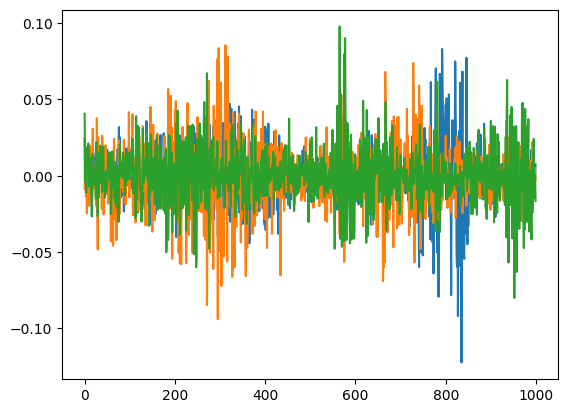

In [14]:
plt.plot(log_returns_sim);